In [2]:
import os
import heapq
import collections
import numpy as np
import matplotlib.pyplot as plt
import json
import PIL
import warnings
import serial
warnings.filterwarnings('ignore')

with open('char_map.json', 'r') as f:
    char_map = json.load(f)

char_map = {int(k): v for k, v in char_map.items()}
reverse_char_map = {v: k for k, v in char_map.items()}

## **Compression and Retrieval**

In [3]:
class TransmissionData():
    def __init__(self, img, huffman_codes):
        self.img = img
        self.information = self.make_string_from_image()
        self.string = '<l>'+str(img.shape[0])+'<h>'+str(img.shape[1])+'<s>'+self.make_string_from_image()+'<e>'
        self.huffman_codes = huffman_codes
        self.encoded_string = self.huffman_encode()
        self.encoded_string_length = len(self.encoded_string)

        self.send()

    def make_string_from_image(self):
        image = self.img
        string = []
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                string.append(char_map[image[i][j]])
        return ''.join(string)
    
    def huffman_encode(self):
        text = self.string
        freq = collections.Counter(text)
        heap = [[weight, [char, '']] for char, weight in freq.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            lo = heapq.heappop(heap)
            hi = heapq.heappop(heap)
            for pair in lo[1:]:
                pair[1] = '0' + pair[1]
            for pair in hi[1:]:
                pair[1] = '1' + pair[1]
            heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

        return ''.join(self.huffman_codes[char] for char in text)

    def show_image(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()

    def send(self):
        ser = serial.Serial("/dev/tty.usbmodem11101", baudrate = 9600, timeout=3)
        for _ in range(2):
            for i in range(len(self.encoded_string)):
                ser.write(bytearray(self.encoded_string[i],'ascii'))
                print(i,ser.readline().decode('ascii'))

    def gen_huffman_codes(images_dir):
        all_strings = []
        for image in os.listdir(images_dir):
            string = []
            img = PIL.Image.open(os.path.join(images_dir, image)).convert('L')
            img = np.array(img).astype(np.uint8)
            img = img//4
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    string.append(char_map[img[i][j]])
    
            string = '<l>'+str(img.shape[0])+'<h>'+str(img.shape[1])+'<s>'+''.join(string)+'<e>'
            all_strings.append(string)

        text = ''.join(all_strings)
        freq = collections.Counter(text)
        heap = [[weight, [char, '']] for char, weight in freq.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            lo = heapq.heappop(heap)
            hi = heapq.heappop(heap)
            for pair in lo[1:]:
                pair[1] = '0' + pair[1]
            for pair in hi[1:]:
                pair[1] = '1' + pair[1]
            heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
        huffman_codes = dict(heapq.heappop(heap)[1:])
        with open('huffman_codes.json', 'w') as f:
            json.dump(huffman_codes, f)

class RecievedData():
    def __init__(self, huffman_codes):

        self.string = self.recieve()
        self.huffman_codes = huffman_codes
        self.decoded_string = self.huffman_decode()
        start = self.decoded_string.find('<s>')+3
        end = start + self.decoded_string[start:].find('<e>')
        start_d = self.decoded_string.find('<l>')+3
        end_d = self.decoded_string.find('<h>')
        legth = int(self.decoded_string[start_d:end_d])
        height = int(self.decoded_string[end_d+3:end_d+5])
        self.dimension = (legth, height)
        self.decoded_string = self.decoded_string[start:end]
        self.img = self.make_image_from_string()



    def huffman_decode(self):
        reverse_huffman_codes = {code: char for char, code in self.huffman_codes.items()}
        decoded_text = ''
        current_code = ''

        for bit in self.string:
            current_code += bit
            if current_code in reverse_huffman_codes:
                char = reverse_huffman_codes[current_code]
                decoded_text += char
                current_code = ''
        return decoded_text

    def make_image_from_string(self):
        string = self.decoded_string
        image = np.zeros(self.dimension, dtype=np.uint8)
        for i in range(self.dimension[0]):
            for j in range(self.dimension[1]):
                image[i][j] = reverse_char_map[string[i*self.dimension[1]+j]]
        return image

    def show_image(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()

    def recieve(self):
        switch = False
        ser = serial.Serial("/dev/tty.usbmodem11101", baudrate = 9600, timeout=3)
        string = ''
        while True:
            string += ser.readline().decode('ascii')
            if '<s>' in string:
                switch = True
            if switch:
                if '<e>' in string:
                    break
        return string


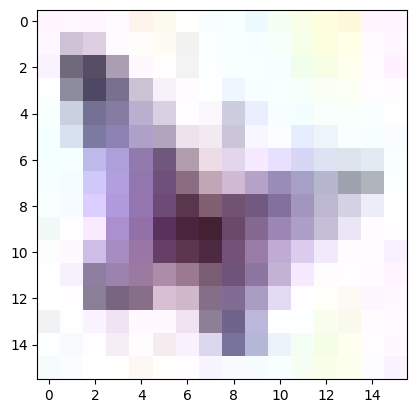

In [5]:
img = PIL.Image.open('images/401254.jpg')
img = img.resize((16,16))
plt.imshow(img, cmap='gray')

# save the image
img.save('images/butterfly.png')

In [64]:
TransmissionData.gen_huffman_codes('images')
huffman_codes = json.load(open('huffman_codes.json', 'r'))

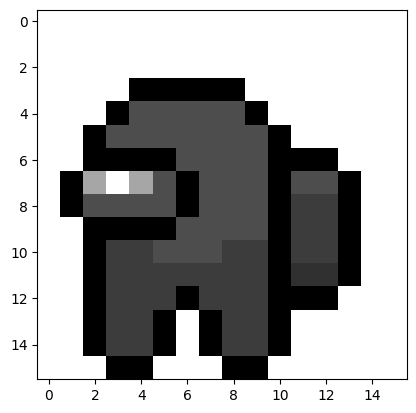

In [65]:
img = np.array(PIL.Image.open('images/amongus.png').convert('L'))
img = img//4
transmission_data = TransmissionData(img, huffman_codes)
transmission_data.show_image()

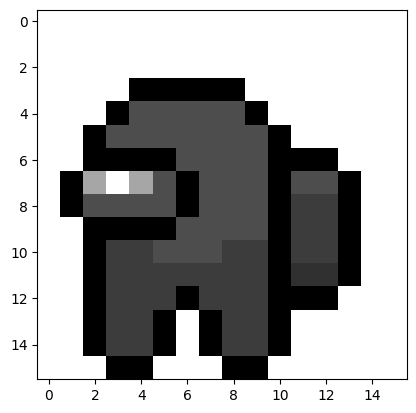

In [66]:
recieved_data = RecievedData(transmission_data.encoded_string, huffman_codes)
recieved_data.show_image()